In [1]:
import numpy as np
import numpy.matlib
import matplotlib.pyplot as plt
from shapely import Polygon,Point,MultiPoint,LineString
from scipy.spatial import ConvexHull
from itertools import combinations
from shapely.ops import unary_union
from IPython.display import display, clear_output
from matplotlib import animation
from sympy import symbols
import numpy.matlib
import matplotlib.colors as mcolors
import shapely as shapely
import random
import pandas as pd
def getPotRegions(X,imp):
    Bx= np.zeros((len(X),4,2));
    for i in range(len(X)):
        Bx[i,0,:]= [X[i][0]-imp, X[i][1]+imp]
        Bx[i,1,:]= [X[i][0]+imp, X[i][1]+imp]
        Bx[i,2,:]= [X[i][0]+imp, X[i][1]-imp]
        Bx[i,3,:]= [X[i][0]-imp, X[i][1]-imp]
    return(Bx);
def getPotRegions_var(X,imp):
    Bx= np.zeros((len(X),4,2));
    for i in range(len(X)):
        Bx[i,0,:]= [X[i][0]-imp[i], X[i][1]+imp[i]]
        Bx[i,1,:]= [X[i][0]+imp[i], X[i][1]+imp[i]]
        Bx[i,2,:]= [X[i][0]+imp[i], X[i][1]-imp[i]]
        Bx[i,3,:]= [X[i][0]-imp[i], X[i][1]-imp[i]]
    return(Bx);
def getPotRegions_var2(X,imp):
    Bx= np.zeros((len(X),4,2));
    for i in range(len(X)):
        Bx[i,0,:]= [float(X[i][0]-imp[i]), float(X[i][1]+imp[i])]
        Bx[i,1,:]= [float(X[i][0]+imp[i]), float(X[i][1]+imp[i])]
        Bx[i,2,:]= [float(X[i][0]+imp[i]), float(X[i][1]-imp[i])]
        Bx[i,3,:]= [float(X[i][0]-imp[i]), float(X[i][1]-imp[i])]
    return(Bx);
def CPIH_Safepoint(n,Bx,Xi):
    k = int(np.floor(2/3*n)+1);
    n = np.arange(n);

    combk = list(combinations(n,k));
    safeX = [];
    safeY =[];
    first= True;
    CPIH= Polygon();
    #testing
   
    for C in combk:
        if Xi in C:
            comb3 = list(combinations(C,3));
            dp1 =[];
            Chull = Polygon();
            for i in range(len(comb3)):
                comb2 = list(combinations(comb3[i][:],2))
                b1 = int(comb3[i][0]);
                b2 = int(comb3[i][1]);
                b3 = int(comb3[i][2]);
                dp1 = np.vstack((Bx[b1,:,:],Bx[b2,:,:],Bx[b3,:,:]));
                idx = ConvexHull(dp1);
                dp1 = Polygon(dp1[idx.vertices,:]);
                dp2 = Polygon();
                for j in range(len(comb2)):
                    a1 = comb2[j][0];
                    a2 = comb2[j][1];
                    temp= np.vstack((Bx[a1,:,:],Bx[a2,:,:]));
                    idx = ConvexHull(temp);
                    temp =  Polygon(temp[idx.vertices,:]);
                    dp2 = unary_union([dp2,temp])
                diff = dp1.difference(dp2);
                Chull= unary_union([Chull,diff]);


            if (first and not Chull.is_empty):
                CPIH = Polygon(Chull.convex_hull);

            else:
                #NEW 
                if not Chull.is_empty:
                    Chull = Polygon(Chull.convex_hull);
                #ENDNEW
                CPIH = CPIH.intersection(Chull);
                if not CPIH.geom_type == 'Polygon' and not CPIH.is_empty:

                    for member in CPIH.geoms:
                        if member.geom_type == 'Polygon':
                            CPIH = member;


                if CPIH.is_empty:
                    return [0,0];
                    break;
            first = False;
    safeX,safeY = np.array(CPIH.exterior.xy)
        #safeX.append(x);
        #safeY.append(y);
    return [safeX,safeY];
    #return CPIH
def maxDist(Xi,safeX,safeY):
    max_dist = 0;
    max_indx = [];
    for i in range(len(safeX)):
        norm = np.linalg.norm(Xi-[safeX[i],safeY[i]]);
        if norm> max_dist:
            max_dist = norm;
            max_indx = [];
            max_indx.append(i);
        elif norm == max_dist:
            max_indx.append(i);
            
    return [np.mean(safeX[max_indx]),np.mean(safeY[max_indx])],max_dist;
def minOrthProj(Xi,Xj,X,f):
    JI = Xj-Xi;
    mindist = 100;
    for i in range(len(X)-f):
        if any(X[i] != Xi) and any(X[i] != Xj):
            AB = X[i]-Xi;
            
            AB_orth = np.array([-AB[1],AB[0]]);
            alt = np.linalg.norm(np.dot(AB_orth,JI)/pow(np.linalg.norm(AB_orth),2)*AB_orth);
            if alt < mindist:
                mindist = alt;
    return mindist;

def get_colors(n,f):
    colors = [plt.cm.get_cmap('viridis',n-f)(i) for i in range(n-f)];
    for attacker in range(f):
        colors.append('r')
    return colors
def ExtractX(lst,i):
    return [item[i][0] for item in lst]
def ExtractY(lst,i):
    return [item[i][1] for item in lst]

def plothull(X):
    hull = ConvexHull(X);
    hullx = np.append(X[hull.vertices,0],X[hull.vertices[0],0]);
    hully = np.append(X[hull.vertices,1],X[hull.vertices[0],1]);
    plt.plot(hullx,hully);
def calcsafepoint(n,Bx):
    n = np.arange(n);
    comb3 = list(combinations(n,3));
    safeX = [];
    safeY =[];
    dp1 =[]
    for i in range(len(comb3)):
        comb2 = list(combinations(comb3[i][:],2))
        b1 = int(comb3[i][0]);
        b2 = int(comb3[i][1]);
        b3 = int(comb3[i][2]);
        dp1 = np.vstack((Bx[b1,:,:],Bx[b2,:,:],Bx[b3,:,:]));
        idx = ConvexHull(dp1);
        dp1 = Polygon(dp1[idx.vertices,:]);
        dp2 = Polygon();
        for j in range(len(comb2)):
            a1 = comb2[j][0];
            a2 = comb2[j][1];
            temp= np.vstack((Bx[a1,:,:],Bx[a2,:,:]));
            idx = ConvexHull(temp);
            temp =  Polygon(temp[idx.vertices,:]);
            dp2 = unary_union([dp2,temp])
        diff = dp1.difference(dp2);
        x,y = np.array(diff.exterior.xy)
        safeX.append(x);
        safeY.append(y);
    return [safeX,safeY]; 
def DBCPIH(n,Xn,Xi):
    k = int(np.floor(2/3*n)+1);
    n = np.arange(n);
    DBCPIH= Polygon();
    combk = list(combinations(n,k));
    safeX = [];
    safeY =[];
    first= True;
  
    for C in combk:
        v =[]
        comb3 = list(combinations(C,3));
        for i in range(len(comb3)):
            safePoint = 1/3*(Xn[comb3[i][0]][:]+Xn[comb3[i][1]][:]+Xn[comb3[i][2]][:]);
            v.append(safePoint)
        v_empty = True
        
        for array in v:
            if v_empty:
                temp = array
                v_empty = False
            else:
                temp= np.vstack((temp,array));
      
        idx = ConvexHull(temp)
      
        Chull  = Polygon(temp[idx.vertices][:])
        if (first and DBCPIH.is_empty):
                DBCPIH = Polygon(Chull.convex_hull);
                first = False;
        else:
            DBCPIH = DBCPIH.intersection(Chull)
           
    if DBCPIH.geom_type == 'Polygon':
        safeX,safeY = np.array(DBCPIH.exterior.xy)
        return np.array((np.mean(safeX), np.mean(safeY)))
    elif DBCPIH.geom_type == 'Point':
        try:
            safeX,safeY = [DBCPIH.x, DBCPIH.y];
        except:
            safeX,safeY = np.array((0,0))
        print(np.array((safeX,safeY)))
        return np.array((safeX,safeY)).T
def getCenterpoint(n,X,i):
    size = int(np.floor(2*n/3)+1)
    n = np.arange(n);
    
    combk = list(combinations(n,size));
    safeX = [];
    safeY =[];
    dp1 =[]
    first = True;
    success = True;
    safeHull = Polygon();
    for comb in combk:
        Xc= np.zeros((size,2));
        j = 0;
        for idx in comb:
            Xc[j,:] = X[idx,:];
            j+=1;
        hullk = ConvexHull(Xc);
         
        dp1 = Polygon(Xc[hullk.vertices,:]);
        if safeHull.is_empty:
            safeHull = dp1;
        try:
            safeHull = safeHull.intersection(dp1);
        except:
            print("could not compute centerpoint for ",X)
            safeHull = safeHull
            success = False
    if safeHull.geom_type == 'Polygon':
        safeX,safeY = np.array(safeHull.exterior.xy)
        if safeX.size == 0  or safeY.size== 0:
            safeX = 0
            safeY = 0
        return[safeX,safeY]
    elif safeHull.geom_type == 'LineString' or safeHull.geom_type == "Point":
        safepoints = np.array(shapely.get_coordinates(safeHull).tolist())
        safeX = safepoints[:,0]
        safeY = safepoints[:,1]
    elif safeHull is None:
        return [0,0]
    else:
        return [0,0]
      

In [134]:
def getCenterpointProjection(n,X,i):
    size = int(np.floor(n/2)+1)
    n = np.arange(n);
    
    combk = list(combinations(n,size));
    safeX = [];
    safeY =[];
    dp1 =[]
    first = True;
    success = True;
    safeHull = Polygon();
    for comb in combk:
        Xc= np.zeros((size,2));
        j = 0;
        for idx in comb:
            Xc[j,:] = X[idx,:];
            j+=1;
        hullk = ConvexHull(Xc);
         
        dp1 = Polygon(Xc[hullk.vertices,:]);
        if safeHull.is_empty:
            safeHull = dp1;
        try:
            safeHull = safeHull.intersection(dp1);
        except:
            print("could not compute centerpoint for ",X)
            safeHull = safeHull
            success = False
    if safeHull.geom_type == 'Polygon':
        safeX,safeY = np.array(safeHull.exterior.xy)
        if safeX.size == 0  or safeY.size== 0:
            safeX = 0
            safeY = 0
        return[safeX,safeY]
    elif safeHull.geom_type == 'LineString' or safeHull.geom_type == "Point":
        safepoints = np.array(shapely.get_coordinates(safeHull).tolist())
        safeX = safepoints[:,0]
        safeY = safepoints[:,1]
    elif safeHull is None:
        return [0,0]
    else:
        return [0,0]
      

In [2]:
def Intersect(a1,a2,b1,b2):
    x = (b2-b1)/(a1-a2)
    y = a1*x+b1
    return (np.array((x,y)))
    
def TukeyMedian(X):
    temp =[]
    k_levels = []
    lower_klevels = []
    upper_klevels = []
    idx = 0
    step =0
    pointies =[]
    checkpoints = []
    minX = np.abs(min(X[:,0]))
    minY = np.abs(min(X[:,1]))
    offset = max(minX,minY)
    for x in X:
        x[0] = x[0]+offset
        x[1] = x[1]+offset
    for n in range(len(X)-1):
        k_levels.append([])
        lower_klevels.append([])
        upper_klevels.append([])
    for n in range(len(X)):
        a1 = X[n][0]
        b1 = X[n][1]
        for q in range(n+1,len(X)):
            a2 =X[q][0]
            b2 = X[q][1]
            
            if not (a1 == a2 and b1 == b2):
               
                if a1 != a2:
                    point= Intersect(-a1,-a2,b1,b2)
                    k,val = vert_intersect(X,point)
                   # for z in range(k+1):
                    k_levels[k].append(point)
                    if val == -1:
                        lower_klevels[k].append(point)
                    if val ==1:
                        upper_klevels[k].append(point)
    
    for i in range(len(k_levels)):
        arr = np.array(k_levels[i])
        k_levels[i] = np.unique(arr, axis =0)
        if len(k_levels[i])>0:
            idx = i;
    empty = True
    while empty:
        empty,kverts,pointies = checkPrimal(k_levels[idx],upper_klevels[idx],lower_klevels[idx],idx)
        if idx == 2:
            checkpoints = pointies
        step = step+1
        if empty and idx != 0:
            idx = idx-1;
        if step>200:
            
            empty = False
    arr = np.array(kverts)
    kverts = np.unique(arr,axis=0)
    for v in kverts:
        v[0] = v[0]-offset
        v[1] = v[1]-offset
    for c in checkpoints:
        c[0] = c[0]-offset
        c[1] = c[1]-offset
    for x in X:
        x[0] = x[0]-offset
        x[1] = x[1]-offset
    if len(kverts)>2:
        try:
            index = ConvexHull(kverts);
            kverts=  kverts[index.vertices,:]
        except:
            index = 0
    
    return idx,kverts#,checkpoints#,upper_klevels,lower_klevels,k_levels,checkpoints
                     
def vert_intersect(X,point):
    upper = 0
    lower = 0
    k =0
    for x in X:
        a = -x[0]
        b = x[1]
        if (a*point[0]+b>point[1] and np.abs(a*point[0]+b- point[1])>.000001):
            upper= upper+1
        if (a*point[0]+b<point[1] and np.abs(a*point[0]+b- point[1])>.000001):
            lower = lower+1
    if lower<upper:
        k = lower
        return (k,-1)
    if upper<lower:
        k = upper
        return(k,1)
    if upper == lower:
        k = upper
        return(k,0)
def checkPrimal(k_levels,upper_klevels,lower_klevels,idx):
    import ipdb
    intersection_empty = True
    kverts =[]
    pointies = []
    for i in range(len(k_levels)-1):
        a1 = k_levels[i][0];
        b1 = k_levels[i][1];
        for j in range(i+1,len(k_levels)):
            a2 = k_levels[j][0];
            b2 = k_levels[j][1];
            if a1 != a2:
                m = (b1-b2)/(a1-a2)
                b = b1-m*a1
                point = np.array((m,b))
           # if a1 != a2:
            #    point = Intersect(a1,a2,b1,b2)
                pointies.append(np.array((-point[0],point[1])))
               
                lower_intersection = True
                upper_intersection = True
                for l in lower_klevels:
                    if point[1]<-l[0]*point[0]+l[1]-.00001:
                        lower_intersection = False
                for u in upper_klevels:
                    if point[1]>-u[0]*point[0]+u[1]+.00001:
                        upper_intersection = False
                if upper_intersection and lower_intersection:
                    intersection_empty = False
                    point[0] = -point[0]
                    kverts.append(point)

    return intersection_empty,kverts,pointies
    

In [5]:
def TukeyMedian2(X):
    upperklevels = []
    lowerklevels= []
    TKl = 0
    TKu = 0
    TK = 0
    kverts = []
    pverts =[]

    for i in range(int(len(X)/2)+1):
        upperklevels.append([])
        lowerklevels.append([])
    for i in range(len(X)-1):
        for j in range(i+1,len(X)):
            m = (X[i][1]-X[j][1])/(X[i][0]-X[j][0])
            b = X[i][1]-X[i][0]*m
            upper = 0
            lower = 0
            for x in X:
                if x[1]>m*x[0]+b+.0001:
                    upper= upper+1
                if x[1]<m*x[0]+b-.0001:
                    lower = lower+1
            if upper<lower:
                upperklevels[upper].append((m,b))
                if upper>TKu:
                    TKu = upper
            if lower<upper:
                lowerklevels[lower].append((m,b))
                if lower>TKl:
                    TKl = lower
    
    TK = min([TKu,TKl])
    klevels = []
    test = True
    step = 0
    while len(kverts)<1:

        TK = min([TKu,TKl])-step
        klevels = []
        test = True
        step=step+1

        for u in upperklevels[TK]:
            klevels.append(u)
        for l in lowerklevels[TK]:
            klevels.append(l)
        for l1 in klevels:
            for l2 in klevels:
                if l1[0]!= l2[0]:
                    is_vert = True
                    pvert = Intersect(l1[0],l2[0],l1[1],l2[1])
                    #print(pvert)
                    pverts.append(pvert)
                    for u in upperklevels[TK]:
                        if u!= l1 and u!=l2:
                            if pvert[1]> u[0]*pvert[0]+u[1]+.0001:
                                is_vert = False
                         #       print(pvert, ' > ', 'u: ', u)
                    for l in lowerklevels[TK]:
                        if l!= l1 and l!=l2:
                            if pvert[1]< l[0]*pvert[0]+l[1]-.0001:
                                is_vert = False
                        #        print(pvert,' < ', 'l: ',l)
                    if is_vert:
                       # print('good',pvert)
                        kverts.append(pvert)
  
    return TK#,kverts#,lowerklevels[TK],upperklevels[TK],pverts
                        
                

In [95]:
X = np.array(((60,24),(56,51),(49,53),(50,16),(91,83),(7,100),(20,2)))
idx,kverts = TukeyMedian2(X)
print(idx)
print(kverts)

2
[array([51.883765  , 45.39734681]), array([53.74305085, 40.49559322]), array([51.883765  , 45.39734681]), array([49.30050688, 41.88124547]), array([49.37188329, 39.2403183 ]), array([50.82113737, 37.16214264]), array([49.30050688, 41.88124547]), array([49.37188329, 39.2403183 ]), array([53.74305085, 40.49559322]), array([50.82113737, 37.16214264])]


In [92]:
print(lowerklevels[2])

[(-26.325586921140463, -29.02491387035753), (0.28282324215165583, -2.626939452909935), (-1.8312992496850056, 0.5100057762110302), (1.2292922579087364, -8.305753547452419), (-1.0997933994120128, -0.20396145174864166)]


In [142]:
def attackerTarget(X):
    n = (int)(np.floor(len(X)/2))
    X = X[X[:,0].argsort()]
    left = X[0:n]
    right = X[n: ]
    point = np.array((0,0))
    goodlm = 0
    goodlb = 0
    goodrm = 0
    goodrb = 0
    r2tested = []
    setmin = 0
    lVert = False
    rVert = False
    for l in left:
        
        xl = 0
        l_idx = np.where(left ==l)[0][0]
        for l2 in left[l_idx:,:]:
            l2_idx = np.where(left ==l)[0][0]
            lVert = False
            if not (l ==l2).all():
                lm = 0
                lb = 0
                ldiff = np.abs(l2[0]-l[0])
                ldiff = ldiff<.0000001
                if (ldiff):
                    lVert = True
                    xl = l[0]
                else:
                    lm = (l2[1]-l[1])/(l2[0]-l[0])
                    lb = l2[1]-l2[0]*lm
                if l2_idx<len(left)-1:
                    left_minus = np.vstack((left[0:l_idx],left[l_idx+1:l2_idx],left[l2_idx+1,:]))
                else:
                    left_minus = np.vstack((left[0:l_idx],left[l_idx+1:l2_idx]))
                if isFacet(lm,lb,xl,left_minus,right,-1):
                    goodlm = lm
                    goodlb = lb
                    for r in right:
                        
                        xr = 0
                        r_idx = np.where(right ==r)[0][0]
                        for r2 in right[r_idx:,:]:
                            rVert = False
                            r2_idx = np.where(right ==r2)[0][0]
                            if not (r == r2).all():
                                r2tested.append((r_idx,r2_idx))
                                rm = 0
                                rb = 0
                                if np.abs(r[0]-r2[0])<.0000001:
                                    rVert = True
                                    xr = r[0]
                                else:
                                    rm = (r2[1]-r[1])/(r2[0]-r[0])
                                    rb = r2[1]-r2[0]*rm
                                if r2_idx<len(right)-1:
                                    right_minus = np.vstack((right[0:r_idx],right[r_idx+1:r2_idx],right[r2_idx+1,:]))
                                else:
                                    right_minus = np.vstack((right[0:r_idx],right[r_idx+1:r2_idx]))
                                if isFacet(rm,rb,xr,right_minus, left,1):
                                    
                                    goodrm = rm
                                    goodrb = rb
                                    if lVert:
                                        px = xl
                                        py = rm*px+rb
                                        if rm<0:
                                            point = np.array((px-1,rm*(px-1.5)+rb))
                                        if rm>0:
                                            point = np.array((px-1,rm*(px-1.5)+rb))
                                    elif rVert:
                                        px = xr
                                        py = lm*px+lb
                                        point = np.array((px+1,lm*(px+1.5)+lb))
                                    else:
                                        px = (rb-lb)/(lm-rm)
                                        py = rm*px+rb
                                        #if (l==np.array((7,100))).all() and (l2==np.array((20,2))).all() and (r ==np.array((56,51))).all() and (r2 ==np.array((91,83))).all():
                                        if lm>=0 and rm<=0: 
                                            lvec = np.linalg.norm(np.array((1,lm)))
                                            rvec =np.linalg.norm(np.array((-1,rm)))
                                        if lm<=0 and rm>=0: 
                                            lvec = np.linalg.norm(np.array((1,lm)))
                                            rvec =np.linalg.norm(np.array((-1,-rm)))
                                        if lm<=0 and rm<=0: 
                                            lvec = np.linalg.norm(np.array((-1,-lm)))
                                            rvec =np.linalg.norm(np.array((-1,-rm)))
                                        if lm>=0 and rm>=0: 
                                            lvec = np.linalg.norm(np.array((1,lm)))
                                            rvec =np.linalg.norm(np.array((1,rm)))
                                        y1 = lm*(px+1)+lb
                                        y2 = rm*(px-1)+rb
                                        point = np.array((px,py))+rvec+lvec
                                        #point =np.array((px,(y1+y2)/2))
                                else:
                                    if r_idx == 0 and r2_idx == 2:
                                        goodrm =rm
                                        goodrb = rb
                                        setmin = np.array(right_minus)
                                        

    return point#,left, right,lVert,rVert,goodlm,goodlb,goodrm,goodrb,setmin,r2tested,ldiff
def isFacet(m,b,x,points,opp_points,LR):
    if len(points) == 0:
        return True
    else:
        facet = True
        under = 0
        if not (x == 0):
            for p in points:
                if LR<0:
                    if p[0]> x+.000001:
                        facet = False
                if LR>0:
                    if p[0]<x-.0000001:
                        facet = False
            for op in opp_points:
                if LR<0:
                    if op[0]<x+.0000001:
                        facet = False
                if LR>0:
                    if op[0]>x-.0000001:
                        facet = False
        else:
        
            if LR <0:
                if m>0:
                    for p in points:
                        if  p[1] < m*p[0]+b:
                            facet = False
                    for op in opp_points:
                        if op[1]>m*op[0]+b:
                            facet = False
                if m<0:
                    for p in points:
                        if  p[1] > m*p[0]+b:
                            facet = False
                    for op in opp_points:
                        if op[1]<m*op[0]+b:
                            facet = False
            if LR >0:
                if m>0:
                    for p in points:
                        if  p[1] > m*p[0]+b:
                            facet = False
                    for op in opp_points:
                        if op[1]<m*op[0]+b:
                            facet = False
                if m<0:
                    for p in points:
                        if  p[1] < m*p[0]+b:
                            facet = False
                    for op in opp_points:
                        if op[1]>m*op[0]+b:
                            facet = False
        return facet
    

In [128]:
import numpy as np
from itertools import combinations

def _find_intersection(p1, p2, p3, p4):
    """Calculates the intersection point of two lines defined by two points each."""
    # Line 1 (p1, p2): A1x + B1y = C1
    a1 = p2[1] - p1[1]
    b1 = p1[0] - p2[0]
    c1 = a1 * p1[0] + b1 * p1[1]

    # Line 2 (p3, p4): A2x + B2y = C2
    a2 = p4[1] - p3[1]
    b2 = p3[0] - p4[0]
    c2 = a2 * p3[0] + b2 * p3[1]

    determinant = a1 * b2 - a2 * b1

    if abs(determinant) < 1e-9: # Lines are parallel
        return None

    x = (b2 * c1 - b1 * c2) / determinant
    y = (a1 * c2 - a2 * c1) / determinant
    
    return np.array([x, y])

def _is_dividing_line(points, line_indices):
    """Checks if a line divides the other points equally."""
    n = points.shape[0]
    p1, p2 = points[line_indices[0]], points[line_indices[1]]
    
    positive_side, negative_side = 0, 0
    
    for i in range(n):
        if i in line_indices:
            continue
        
        # Use cross-product to determine which side of the line a point is on
        cross_product = (p2[0] - p1[0]) * (points[i, 1] - p1[1]) - \
                        (p2[1] - p1[1]) * (points[i, 0] - p1[0])
                        
        if cross_product > 1e-9: # Epsilon for float precision
            positive_side += 1
        elif cross_product < -1e-9:
            negative_side += 1
            
    return positive_side == negative_side and positive_side == (n - 2) / 2

def TV_Projection(points: np.ndarray) -> np.ndarray:
    """
    Transforms a set of points to be centrosymmetric.

    Args:
        points: An n x 2 NumPy array of (x, y) coordinates, where n is even.

    Returns:
        An n x 2 NumPy array with the adjusted point coordinates.
    """
    n = points.shape[0]
    if n % 2 != 0:
        raise ValueError("The number of points (n) must be even.")

    all_indices = list(range(n))

    # --- 1. Find the first dividing line ---
    first_line_indices = None
    for p_indices in combinations(all_indices, 2):
        if _is_dividing_line(points, p_indices):
            first_line_indices = p_indices
            break
    
    if first_line_indices is None:
        raise RuntimeError("Could not find a line that divides the points equally.")

    # --- 2. Find the second, most orthogonal dividing line ---
    second_line_indices = None
    min_abs_dot_product = float('inf')
    v1 = points[first_line_indices[1]] - points[first_line_indices[0]]
    
    # Iterate through pairs that don't include the first line's points
    available_indices = list(set(all_indices) - set(first_line_indices))
    for p_indices in combinations(available_indices, 2):
        if _is_dividing_line(points, p_indices):
            v2 = points[p_indices[1]] - points[p_indices[0]]
            abs_dot = abs(np.dot(v1, v2))
            
            if abs_dot < min_abs_dot_product:
                min_abs_dot_product = abs_dot
                second_line_indices = p_indices

    if second_line_indices is None:
        raise RuntimeError("Could not find a second orthogonal dividing line.")

    # --- 3. Adjust points to be centrosymmetric ---
    # Find the intersection point
    p1, p2 = points[first_line_indices[0]], points[first_line_indices[1]]
    p3, p4 = points[second_line_indices[0]], points[second_line_indices[1]]
    intersection_point = _find_intersection(p1, p2, p3, p4)

    if intersection_point is None:
        raise RuntimeError("The two dividing lines are parallel and do not intersect.")

    # Identify the n-4 points to be adjusted
    line_point_indices = set(first_line_indices) | set(second_line_indices)
    points_to_adjust_indices = list(set(all_indices) - line_point_indices)
    
    # Greedily pair the closest points to be adjusted
    unpaired_indices = points_to_adjust_indices.copy()
    pairs = []
    while unpaired_indices:
        current_idx = unpaired_indices.pop(0)
        # Find the index of the closest point in the remaining list
        partner_idx = min(unpaired_indices, 
                          key=lambda idx: np.linalg.norm(points[idx] - points[current_idx]))
        unpaired_indices.remove(partner_idx)
        pairs.append((current_idx, partner_idx))
    
    # Reposition each pair symmetrically around the intersection point
    adjusted_points = points.copy()
    for idx_a, idx_b in pairs:
        p_a, p_b = points[idx_a], points[idx_b]
        
        # Vector from the pair's midpoint to point A
        vec_mid_to_a = (p_a - p_b) / 2.0
        
        # Place the points symmetrically around the intersection
        adjusted_points[idx_a] = intersection_point + vec_mid_to_a
        adjusted_points[idx_b] = intersection_point - vec_mid_to_a

    return adjusted_points, intersection_point
    


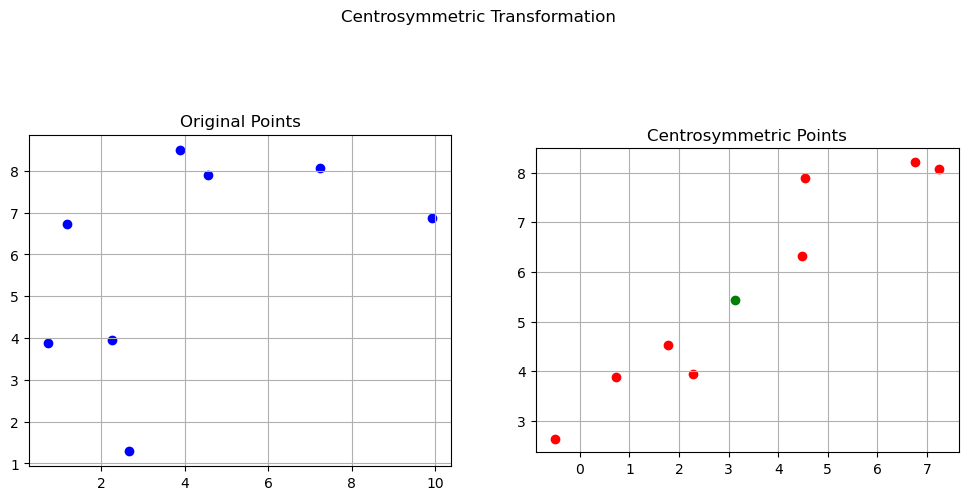

In [123]:
import matplotlib.pyplot as plt

# Generate 12 random 6points
n_points = 8
original_points = np.random.rand(n_points, 2) * 10

# Run the transformation
try:
    symmetric_points,intersection_point = make_centrosymmetric(original_points)

    # --- Visualization ---
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))

    ax1.scatter(original_points[:, 0], original_points[:, 1], c='blue', label='Original Points')
    ax1.set_title('Original Points')
    ax1.set_aspect('equal', adjustable='box')
    ax1.grid(True)

    ax2.scatter(symmetric_points[:, 0], symmetric_points[:, 1], c='red', label='Symmetric Points')
    ax2.set_title('Centrosymmetric Points')
    ax2.set_aspect('equal', adjustable='box')
    ax2.grid(True)
    ax2.scatter(intersection_point[0],intersection_point[1], c = 'green')
    plt.suptitle('Centrosymmetric Transformation')
    plt.show()

except (RuntimeError, ValueError) as e:
    print(f"An error occurred: {e}")

In [19]:
temp = Xhist[0]
for i in range(1,len(Xhist)):
    temp = np.vstack((temp,Xhist[i]))
df = pd.DataFrame(temp)
df.to_csv("Xhist.csv")

In [119]:
print(intersection_point)

[5.43173342 5.25627385]


HALFSPACE SYMMETRIC ALWAYS

C:\Users\85chr\AppData\Local\Temp\ipykernel_25528\2944431226.py:128: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  colors = [plt.cm.get_cmap('viridis',n-f)(i) for i in range(n-f)];
C:\Users\85chr\AppData\Local\Temp\ipykernel_25528\3202936341.py:80: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  ax.scatter(X[i,0],X[i,1],c= colors[i], marker = 'o',label = lbl,s =50);
C:\Users\85chr\AppData\Local\Temp\ipykernel_25528\3202936341.py:173: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided 

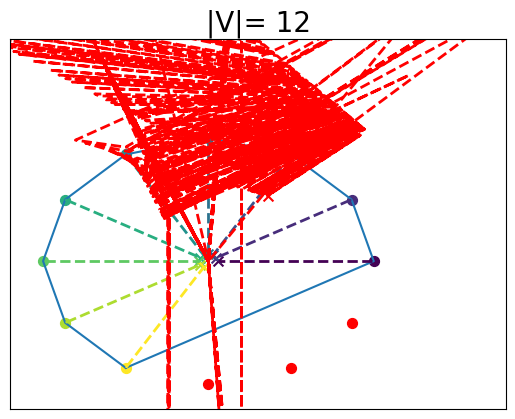

In [9]:
fig, ax = plt.subplots()
#fig2,ax2 = plt.subplots()

n = 12
offset = np.ones((n,2))*.5;
X= 10*(np.random.rand(n,2)-offset)
#n = 6
for i in range(n):
    theta = 2*np.pi/(n)*i
    X[i] = np.array((5*np.cos(theta),5*np.sin(theta)))
#X = np.array([(-3,-1), (-3, 4),(0.5 ,-4),(1.5,6),(3.5,2),(4,-1)]);
#X[n-1]= np.array((5,1))
attackers = [n-1]
if n >6:
    #X[n-2] = np.array((6,-1))
    attackers = [n-2,n-1]
if n>9:
   # X[n-3] = np.array((7,-3))
    attackers = [n-3,n-2,n-1];
attackerTargetHist = []
attackerTargetHist.append([])
attackerTargetHist.append([])
attackerTargetHist.append([])
Xn = np.zeros((n,9,2));
#Xn = np.zeros((8,8,2))
N = []

for i in range(n):
    retry = True
    while retry:
        q = 0
        nh = random.sample(range(n),9)
        for attacker in attackers:
            if attacker in nh:
                q= q+1
        if q<3:
            N.append(nh)
            Xn[i][:] = X[N[i]]
            retry = False

   
f = len(attackers);
#imp = .5*np.ones((6,6))-.5*np.eye(6);
imp = 0.5;
colors= get_colors(n,f);
empty = False;


frames = [];
step = 0;
emptyCPIH = np.zeros((n,1));
Xhist = [];
Yhist = [];
hull = ConvexHull(X[0:n-f]);
xplot = [];
yplot = [];
ham = 0;
#attackerTarget = [np.array((6,6)),np.array((6,6)),np.array((6,-6))]
Bx = getPotRegions(X,imp);
imprecision = False
if imprecision:
    for j in range(n):
            x = []; y = [];
            for k in range(4):
                x.append(Bx[j,k,0]);
                y.append(Bx[j,k,1]);
            x.append(Bx[j,0,0]);
            y.append(Bx[j,0,1]);
                #ax.scatter(x,y)
            ax.plot(x,y,c= colors[j]);
imp = 0
for v in hull.vertices:
    xplot.append(X[v,0]);
    yplot.append(X[v,1]);
xplot.append(X[hull.vertices[0],0]);
yplot.append(X[hull.vertices[0],1]);
ax.plot(xplot,yplot,label = 'Conv('+r'$X_0$'+')');
for i in range(n-f):
    lbl = r'$v_{s1}$'.replace('s1',str(i+1));
    ax.scatter(X[i,0],X[i,1],c= colors[i], marker = 'o',label = lbl,s =50);

for idx in attackers:
    lbl = r'$v_f$'#+str(attackers.index(idx)+1);
    ax.scatter(X[idx,0],X[idx,1],c= colors[idx], marker = 'o',label = lbl,s = 50);
maxdist = np.zeros((1,602))
target = np.zeros((n,2));
targetdist=np.zeros((n,1));
snapshot= (0,80,160,240,300,600)
imphist = [];
tm = []
attackedHood = [[],[],[]]
while not empty:
   
    #ax.cla();
   # ax.set_xlim(-7,7);
   # ax.set_ylim(-7,7);
    dt = .01;
    n = len(X);
    
    safeX= [];
    safeY=[];
    dist = 0;

    for i in range(n):
        if i not in attackers:
                    Xn[i][:] = X[N[i]]#X+np.matlib.repmat(a,6,1);
        if i not in attackers:
            #safeX,safeY = CPIH_Safepoint(n,Bx,i);
            try:
                #safeX,safeY = getCenterpoint(6,Xn[i],i);
                
                theta = 2*np.pi/(n)*i
                target[i] = np.array((5*(1/step)*np.cos(theta),5*(1/step)*np.sin(theta)))
                #print("agent",i," has safepoint:",np.mean(safeX),", ",np.mean(safeY))
            except:
                safeX,safeY = [0,0]
                #print("no Safepoints")
            #CPIH = CPIH_Safepoint(n,Bx);
            #safeX,safeY = optConfig(Xn[i],i,imp);
            #if (isinstance(safeX,int) and isinstance(safeY,int)) or safeX.size ==0:
                #print('CPIH empty');
                #empty = True;
             #   emptyCPIH[i] = 1;
              #  target[i] = X[i]
            #else:
             #   target[i] = [np.mean(safeX), np.mean(safeY)];

                    
               # emptyCPIH[i] =1;
         
        elif i in attackers:
            firstfound = False
            used = []
            for j in range(len(N)):
                if not firstfound and j not in used:
                    for k in range(len(N[j])):
                        if N[j][k] == i:
                            used.append(j)
                            temp = np.delete(X[N[j]],k, axis = 0)
                            target[i]= attackerTarget(temp)
                            firstfound = True
                            attackerTargetHist[attackers.index(i)].append(target[i])
                            attackedHood[attackers.index(i)].append(j)
           # target[i] = attackerTarget[attackers.index(i)];
       
                
        

    for i in range(n):
        X[i]= X[i]+dt*(target[i]-X[i]);
    for i in attackers:
        X[i] = target[i]
    Xhist.append(X.copy());

    
    
    if step>300:
        empty = True;

  
    for i in range(n-len(attackers)):
        for j in range(n-len(attackers)):
            temp = np.linalg.norm(X[i]-X[j]);
            if temp> maxdist[0][step]:
                maxdist[0][step] = temp;
    step +=1;

for i in range(n):
    xplot = ExtractX(Xhist,i);
    yplot = ExtractY(Xhist,i);
    endn = len(xplot);
    ax.plot(xplot,yplot,c = colors[i],linestyle='dashed',linewidth= 2);
    ax.scatter(xplot[endn-1],yplot[endn-1],c = colors[i], marker='x',s=50);
ax.set_xlim(-6,9);
ax.set_ylim(-6,9);
ax.set_xticks([])
ax.set_yticks([])
plt.title('|V|= '+str(n),fontsize = 20);
plt.savefig("Centerpoint_trajectories_n"+str(n)+"_f"+str(f)+".jpg")

CENTERPOINT

C:\Users\85chr\AppData\Local\Temp\ipykernel_25528\3658514568.py:128: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  colors = [plt.cm.get_cmap('viridis',n-f)(i) for i in range(n-f)];
C:\Users\85chr\AppData\Local\Temp\ipykernel_25528\2865764463.py:75: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  ax.scatter(X[i,0],X[i,1],c= colors[i], marker = 'o',label = lbl,s =50);
C:\Users\85chr\anaconda3\Lib\site-packages\shapely\set_operations.py:131: RuntimeWarning: divide by zero encountered in intersection
  return lib.intersection(a, b, **kw

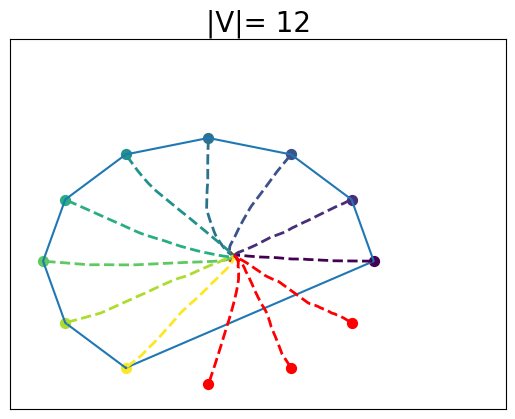

In [107]:
fig, ax = plt.subplots()
#fig2,ax2 = plt.subplots()

n = 12
offset = np.ones((n,2))*.5;
X= 10*(np.random.rand(n,2)-offset)
#n = 6
for i in range(n):
    theta = 2*np.pi/(n)*i
    X[i] = np.array((5*np.cos(theta),5*np.sin(theta)))
#X = np.array([(-3,-1), (-3, 4),(0.5 ,-4),(1.5,6),(3.5,2),(4,-1)]);
#X[n-1]= np.array((5,1))
attackers = [n-1]

if n >6:
    #X[n-2] = np.array((6,-1))
    attackers = [n-2,n-1]
    
if n>9:
   # X[n-3] = np.array((7,-3))
    attackers = [n-3,n-2,n-1];
attackmode = 0
attackerTargetHist = []
attackerTargetHist.append([])
attackerTargetHist.append([])
attackerTargetHist.append([])
Xn = np.zeros((n,9,2));
#Xn = np.zeros((8,8,2))
N = []
f = len(attackers);
for i in range(n):
    
    nh = random.sample(range(n-f),6)
    for attacker in attackers:
        nh.append(attacker)
    
    N.append(nh)
    Xn[i][:] = X[N[i]]

#imp = .5*np.ones((6,6))-.5*np.eye(6);
imp = 0.5;
colors= get_colors(n,f);
empty = False;


frames = [];
step = 0;
emptyCPIH = np.zeros((n,1));
Xhist = [];
Yhist = [];
hull = ConvexHull(X[0:n-f]);
xplot = [];
yplot = [];
ham = 0;
#attackerTarget = [np.array((6,6)),np.array((6,6)),np.array((6,-6))]
Bx = getPotRegions(X,imp);
imprecision = False
if imprecision:
    for j in range(n):
            x = []; y = [];
            for k in range(4):
                x.append(Bx[j,k,0]);
                y.append(Bx[j,k,1]);
            x.append(Bx[j,0,0]);
            y.append(Bx[j,0,1]);
                #ax.scatter(x,y)
            ax.plot(x,y,c= colors[j]);
imp = 0
for v in hull.vertices:
    xplot.append(X[v,0]);
    yplot.append(X[v,1]);
xplot.append(X[hull.vertices[0],0]);
yplot.append(X[hull.vertices[0],1]);
ax.plot(xplot,yplot,label = 'Conv('+r'$X_0$'+')');
for i in range(n-f):
    lbl = r'$v_{s1}$'.replace('s1',str(i+1));
    ax.scatter(X[i,0],X[i,1],c= colors[i], marker = 'o',label = lbl,s =50);

for idx in attackers:
    lbl = r'$v_f$'#+str(attackers.index(idx)+1);
    ax.scatter(X[idx,0],X[idx,1],c= colors[idx], marker = 'o',label = lbl,s = 50);
maxdist = np.zeros((1,602))
target = np.zeros((n,2));
targetdist=np.zeros((n,1));
snapshot= (0,80,160,240,300,600)
imphist = [];
tm = []
attackedHood = [[],[],[]]
while not empty:
   
    #ax.cla();
   # ax.set_xlim(-7,7);
   # ax.set_ylim(-7,7);
    dt = .01;
    n = len(X);
    
    safeX= [];
    safeY=[];
    dist = 0;

    for i in range(n):
        if i not in attackers or attackmode == 0:
                    Xn[i][:] = X[N[i]]#X+np.matlib.repmat(a,6,1);
        if i not in attackers:
            #safeX,safeY = CPIH_Safepoint(n,Bx,i);
            try:
                safeX,safeY = getCenterpoint(9,Xn[i],i);
                #print("safeX:",safeX, " safeY:", safeY)
                target[i] = [np.mean(safeX), np.mean(safeY)]
                #theta = 2*np.pi/(n)*i
                #target[i] = np.array((5*(1/step)*np.cos(theta),5*(1/step)*np.sin(theta)))
                #print("agent",i," has safepoint:",np.mean(safeX),", ",np.mean(safeY))
            except Exception as e:
                print("An exception occurred:", type(e).__name__)
                safeX,safeY = [0,0]
                print("no Safepoints")
            #CPIH = CPIH_Safepoint(n,Bx);
            #safeX,safeY = optConfig(Xn[i],i,imp);
            #if (isinstance(safeX,int) and isinstance(safeY,int)) or safeX.size ==0:
                #print('CPIH empty');
                #empty = True;
             #   emptyCPIH[i] = 1;
              #  target[i] = X[i]
            #else:
                target[i] = X[i];

                    
               # emptyCPIH[i] =1;
         
        elif i in attackers:
            if attackmode == 0:
                try:
                    safeX,safeY = getCenterpoint(9,Xn[i],i);
                    target[i] = [np.mean(safeX), np.mean(safeY)]
                except Exception as e:
                    print("An exception occurred:", type(e).__name__)
                    safeX,safeY = [0,0]
                    print("no Safepoints")
            if attackmode == 1:
                target[i] = X[i]
            if attackmode == 2:
                firstfound = False
                used = []
                for j in range(len(N)):
                    if not firstfound and j not in used:
                        for k in range(len(N[j])):
                            if N[j][k] == i:
                                used.append(j)
                                temp = np.delete(X[N[j]],k, axis = 0)
                                target[i]= attackerTarget(temp)
                                firstfound = True
                                attackerTargetHist[attackers.index(i)].append(target[i])
                                attackedHood[attackers.index(i)].append(j)
           # target[i] = attackerTarget[attackers.index(i)];
       
                
        

    for i in range(n):
        X[i]= X[i]+dt*(target[i]-X[i]);
    for i in attackers:
        if attackmode == 0:
            X[i] = X[i]+dt*(target[i]-X[i]);
        else:
            X[i] = target[i]
    Xhist.append(X.copy());

    if step>600:
        empty = True;

  
    for i in range(n-len(attackers)):
        for j in range(n-len(attackers)):
            temp = np.linalg.norm(X[i]-X[j]);
            if temp> maxdist[0][step]:
                maxdist[0][step] = temp;
    step +=1;

for i in range(n):
    xplot = ExtractX(Xhist,i);
    yplot = ExtractY(Xhist,i);
    endn = len(xplot);
    ax.plot(xplot,yplot,c = colors[i],linestyle='dashed',linewidth= 2);
    ax.scatter(xplot[endn-1],yplot[endn-1],c = colors[i], marker='x',s=50);
ax.set_xlim(-6,9);
ax.set_ylim(-6,9);
ax.set_xticks([])
ax.set_yticks([])
plt.title('|V|= '+str(n),fontsize = 20);
plt.savefig("Centerpoint_trajectories_n"+str(n)+"_f"+str(f)+".jpg")

ISOTROPIC CONTROL

C:\Users\85chr\AppData\Local\Temp\ipykernel_32184\3658514568.py:128: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  colors = [plt.cm.get_cmap('viridis',n-f)(i) for i in range(n-f)];
C:\Users\85chr\AppData\Local\Temp\ipykernel_32184\3829224472.py:76: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  ax.scatter(X[i,0],X[i,1],c= colors[i], marker = 'o',label = lbl,s =50);


ks*(C-trace/2*I)  [[-1.26060818 -0.09429548]
 [-0.09429548  1.26060818]]
centroid-X[i]  [-2.39581122 -1.04236241]
ks*(C-trace/2*I)  [[-0.3011269 -0.1777455]
 [-0.1777455  0.3011269]]
centroid-X[i]  [0.05992735 0.75913855]
ks*(C-trace/2*I)  [[-1.46122842 -0.15213412]
 [-0.15213412  1.46122842]]
centroid-X[i]  [ 0.55130949 -2.05163521]
ks*(C-trace/2*I)  [[-1.20170595 -0.35647061]
 [-0.35647061  1.20170595]]
centroid-X[i]  [ 0.99211655 -5.03633535]
ks*(C-trace/2*I)  [[-0.18641795  0.05886749]
 [ 0.05886749  0.18641795]]
centroid-X[i]  [-1.73808023  0.55035188]
ks*(C-trace/2*I)  [[-1.39174859 -0.48060094]
 [-0.48060094  1.39174859]]
centroid-X[i]  [1.76780052 2.51070559]
ks*(C-trace/2*I)  [[-1.24161738 -0.73293606]
 [-0.73293606  1.24161738]]
centroid-X[i]  [-0.63748084  3.53568182]
ks*(C-trace/2*I)  [[-0.3011269 -0.1777455]
 [-0.1777455  0.3011269]]
centroid-X[i]  [-0.26372026 -0.50676277]
ks*(C-trace/2*I)  [[-1.11461655 -0.8019891 ]
 [-0.8019891   1.11461655]]
centroid-X[i]  [1.54892486 

C:\Users\85chr\AppData\Local\Temp\ipykernel_32184\3829224472.py:175: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  ax.scatter(xplot[endn-1],yplot[endn-1],c = colors[i], marker='x',s=50);


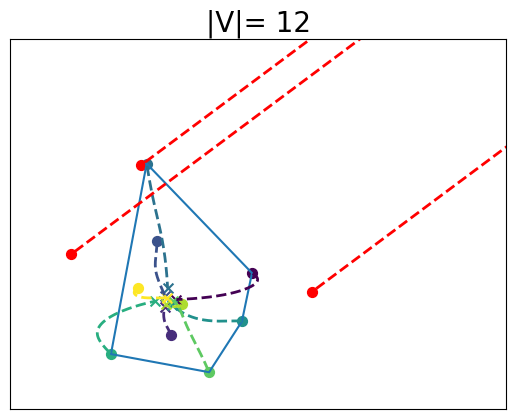

In [105]:
fig, ax = plt.subplots()
#fig2,ax2 = plt.subplots()

n = 12
offset = np.ones((n,2))*.5;
X= 10*(np.random.rand(n,2)-offset)

attackers = [n-1]

if n >6:
    #X[n-2] = np.array((6,-1))
    attackers = [n-2,n-1]
    
if n>9:
   # X[n-3] = np.array((7,-3))
    attackers = [n-3,n-2,n-1];
attackmode = 3
attackerTargetHist = []
attackerTargetHist.append([])
attackerTargetHist.append([])
attackerTargetHist.append([])
Xn = np.zeros((n,9,2));
#Xn = np.zeros((8,8,2))
N = []
f = len(attackers);
for i in range(n):
    
    nh = random.sample(range(n-f),7)
    anh = random.sample(range(n-f,n),2)
    nh = np.append(nh,anh)
    #for attacker in attackers:
     #   nh.append(attacker)
    
    N.append(nh)
    Xn[i][:] = X[N[i]]

#imp = .5*np.ones((6,6))-.5*np.eye(6);
imp = 0.5;
colors= get_colors(n,f);
empty = False;


frames = [];
step = 0;
emptyCPIH = np.zeros((n,1));
Xhist = [];
Yhist = [];
hull = ConvexHull(X[0:n-f]);
xplot = [];
yplot = [];
ham = 0;

Bx = getPotRegions(X,imp);
imprecision = False
ks = 0.5
kc = 0.5
if imprecision:
    for j in range(n):
            x = []; y = [];
            for k in range(4):
                x.append(Bx[j,k,0]);
                y.append(Bx[j,k,1]);
            x.append(Bx[j,0,0]);
            y.append(Bx[j,0,1]);
                #ax.scatter(x,y)
            ax.plot(x,y,c= colors[j]);
imp = 0
for v in hull.vertices:
    xplot.append(X[v,0]);
    yplot.append(X[v,1]);
xplot.append(X[hull.vertices[0],0]);
yplot.append(X[hull.vertices[0],1]);
ax.plot(xplot,yplot,label = 'Conv('+r'$X_0$'+')');
for i in range(n-f):
    lbl = r'$v_{s1}$'.replace('s1',str(i+1));
    ax.scatter(X[i,0],X[i,1],c= colors[i], marker = 'o',label = lbl,s =50);

for idx in attackers:
    lbl = r'$v_f$'#+str(attackers.index(idx)+1);
    ax.scatter(X[idx,0],X[idx,1],c= colors[idx], marker = 'o',label = lbl,s = 50);
maxdist = np.zeros((1,602))
target = np.zeros((n,2));
targetdist=np.zeros((n,1));
snapshot= (0,80,160,240,300,600)
tm = []
attackedHood = [[],[],[]]
while step <500:
   
    #ax.cla();
   # ax.set_xlim(-7,7);
   # ax.set_ylim(-7,7);
    dt = .01;
    n = len(X);
    
    safeX= [];
    safeY=[];
    dist = 0;

    for i in range(n):
        if i not in attackers or attackmode == 0:
                    Xn[i][:] = X[N[i]]#X+np.matlib.repmat(a,6,1);
        if i not in attackers:
            #safeX,safeY = CPIH_Safepoint(n,Bx,i);
            
            centroid = np.array((np.mean(Xn[i][0:7,0]),np.mean(Xn[i][0:7,1])))
            C = np.zeros((2,2))
            for neighbor in range(7):
                pos = Xn[i][neighbor]-centroid
                C= C+ np.outer(pos,pos)
            C = C/(7)
            trace = C[0][0]+C[1][1]
            I = np.eye(2)
           
            print("ks*(C-trace/2*I) ", ks*(C-trace/2*I))
            print("centroid-X[i] ",centroid-X[i])
            target[i] = ks*(C-trace/2*I)@(centroid-X[i])+kc*(centroid-X[i])

         
        elif i in attackers:
            if attackmode == 0:
                try:
                    safeX,safeY = getCenterpoint(9,Xn[i],i);
                    target[i] = [np.mean(safeX), np.mean(safeY)]
                except Exception as e:
                    print("An exception occurred:", type(e).__name__)
                    safeX,safeY = [0,0]
                    print("no Safepoints")
            if attackmode == 1:
                target[i] = X[i]
            if attackmode == 2:
                firstfound = False
                used = []
                for j in range(len(N)):
                    if not firstfound and j not in used:
                        for k in range(len(N[j])):
                            if N[j][k] == i:
                                used.append(j)
                                temp = np.delete(X[N[j]],k, axis = 0)
                                target[i]= attackerTarget(temp)
                                firstfound = True
                                attackerTargetHist[attackers.index(i)].append(target[i])
                                attackedHood[attackers.index(i)].append(j)
            if attackmode == 3:
                target[i]= np.array((6,6))
           # target[i] = attackerTarget[attackers.index(i)];
       
                
        

    for i in range(n):
        X[i]= X[i]+dt*(target[i]);
    for i in attackers:
        if attackmode == 0:
            X[i] = X[i]+dt*(target[i]);
        else:
            X[i] = X[i]+dt*target[i]
    Xhist.append(X.copy());

    if step>600:
        empty = True;

  
    for i in range(n-len(attackers)):
        for j in range(n-len(attackers)):
            temp = np.linalg.norm(X[i]-X[j]);
            if temp> maxdist[0][step]:
                maxdist[0][step] = temp;
    step +=1;

for i in range(n):
    xplot = ExtractX(Xhist,i);
    yplot = ExtractY(Xhist,i);
    endn = len(xplot);
    ax.plot(xplot,yplot,c = colors[i],linestyle='dashed',linewidth= 2);
    ax.scatter(xplot[endn-1],yplot[endn-1],c = colors[i], marker='x',s=50);
ax.set_xlim(-6,9);
ax.set_ylim(-6,9);
ax.set_xticks([])
ax.set_yticks([])
plt.title('|V|= '+str(n),fontsize = 20);
plt.savefig("SymmetricControl_trajectories_n"+str(n)+"_f"+str(f)+".jpg")

In [93]:
n = 12
offset = np.ones((n,2))*.5;
X= 10*(np.random.rand(n,2)-offset)

centroid = np.array((np.mean(X[:][0]),np.mean(X[:][1])))
print(centroid)
C = np.zeros((2,2))
print(C)
print(np.outer(centroid,centroid))
print(np.eye(2))
print(X[0:5][:])

[-0.14418994 -0.28779439]
[[0. 0.]
 [0. 0.]]
[[0.02079074 0.04149706]
 [0.04149706 0.08282561]]
[[1. 0.]
 [0. 1.]]
[[-1.80211558  1.5137357 ]
 [ 0.86712137 -1.44271016]
 [ 2.72738417 -0.02707618]
 [ 0.09643012 -2.77253576]
 [ 3.19947631  4.15393718]]


TVPROJECTION

C:\Users\85chr\AppData\Local\Temp\ipykernel_32184\3658514568.py:128: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  colors = [plt.cm.get_cmap('viridis',n-f)(i) for i in range(n-f)];
C:\Users\85chr\AppData\Local\Temp\ipykernel_32184\536400517.py:77: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  ax.scatter(X[i,0],X[i,1],c= colors[i], marker = 'o',label = lbl,s =50);


RuntimeError: Could not find a second orthogonal dividing line.

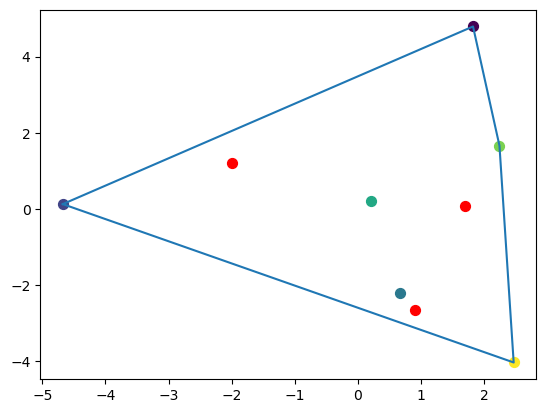

In [146]:
fig, ax = plt.subplots()
#fig2,ax2 = plt.subplots()

n = 9
offset = np.ones((n,2))*.5;
X= 10*(np.random.rand(n,2)-offset)
#n = 6

#X = np.array([(-3,-1), (-3, 4),(0.5 ,-4),(1.5,6),(3.5,2),(4,-1)]);
#X[n-1]= np.array((5,1))
attackers = [n-1]

if n >6:
    #X[n-2] = np.array((6,-1))
    attackers = [n-4,n-3,n-2,n-1]
    
if n>9:
   # X[n-3] = np.array((7,-3))
    attackers = [n-3,n-2,n-1];
attackmode = 2
attackerTargetHist = []
attackerTargetHist.append([])
attackerTargetHist.append([])
attackerTargetHist.append([])
attackerTargetHist.append([])
Xn = np.zeros((n,8,2));
#Xn = np.zeros((8,8,2))
N = []
attackers = [n-3,n-2,n-1]
f = len(attackers);
for i in range(n):
    
    nh = random.sample(range(n-f),5)
    for attacker in attackers:
        nh.append(attacker)
    
    N.append(nh)
    Xn[i][:] = X[N[i]]

#imp = .5*np.ones((6,6))-.5*np.eye(6);
imp = 0.5;
colors= get_colors(n,f);
empty = False;


frames = [];
step = 0;
emptyCPIH = np.zeros((n,1));
Xhist = [];
Yhist = [];
hull = ConvexHull(X[0:n-f]);
xplot = [];
yplot = [];
ham = 0;
#attackerTarget = [np.array((6,6)),np.array((6,6)),np.array((6,-6))]
Bx = getPotRegions(X,imp);
imprecision = False
if imprecision:
    for j in range(n):
            x = []; y = [];
            for k in range(4):
                x.append(Bx[j,k,0]);
                y.append(Bx[j,k,1]);
            x.append(Bx[j,0,0]);
            y.append(Bx[j,0,1]);
                #ax.scatter(x,y)
            ax.plot(x,y,c= colors[j]);
imp = 0
for v in hull.vertices:
    xplot.append(X[v,0]);
    yplot.append(X[v,1]);
xplot.append(X[hull.vertices[0],0]);
yplot.append(X[hull.vertices[0],1]);
ax.plot(xplot,yplot,label = 'Conv('+r'$X_0$'+')');
for i in range(n-f):
    lbl = r'$v_{s1}$'.replace('s1',str(i+1));
    ax.scatter(X[i,0],X[i,1],c= colors[i], marker = 'o',label = lbl,s =50);

for idx in attackers:
    lbl = r'$v_f$'#+str(attackers.index(idx)+1);
    ax.scatter(X[idx,0],X[idx,1],c= colors[idx], marker = 'o',label = lbl,s = 50);
maxdist = np.zeros((1,602))
target = np.zeros((n,2));
targetdist=np.zeros((n,1));
snapshot= (0,80,160,240,300,600)
imphist = [];
tm = []
attackedHood = [[],[],[]]
while step<300:
   
    #ax.cla();
   # ax.set_xlim(-7,7);
   # ax.set_ylim(-7,7);
    dt = .01;
    n = len(X);
    
    safeX= [];
    safeY=[];
    dist = 0;

    for i in range(n):
        if i not in attackers or attackmode == 0:
                    Xn[i][:],center = TV_Projection(X[N[i]])#X+np.matlib.repmat(a,6,1);
        if i not in attackers:
            #safeX,safeY = CPIH_Safepoint(n,Bx,i);
            try:
                safeX,safeY = getCenterpointProjection(8,Xn[i],i);
                #print("safeX:",safeX, " safeY:", safeY)
                target[i] = [np.mean(safeX), np.mean(safeY)]
                #theta = 2*np.pi/(n)*i
                #target[i] = np.array((5*(1/step)*np.cos(theta),5*(1/step)*np.sin(theta)))
                #print("agent",i," has safepoint:",np.mean(safeX),", ",np.mean(safeY))
            except Exception as e:
                print("An exception occurred:", type(e).__name__)
                safeX,safeY = [0,0]
                print("no Safepoints")
            #CPIH = CPIH_Safepoint(n,Bx);
            #safeX,safeY = optConfig(Xn[i],i,imp);
            #if (isinstance(safeX,int) and isinstance(safeY,int)) or safeX.size ==0:
                #print('CPIH empty');
                #empty = True;
             #   emptyCPIH[i] = 1;
              #  target[i] = X[i]
            #else:
                target[i] = X[i];

                    
               # emptyCPIH[i] =1;
         
        elif i in attackers:
            if attackmode == 0:
                try:
                    safeX,safeY = getCenterpoint(9,Xn[i],i);
                    target[i] = [np.mean(safeX), np.mean(safeY)]
                except Exception as e:
                    print("An exception occurred:", type(e).__name__)
                    safeX,safeY = [0,0]
                    print("no Safepoints")
            if attackmode == 1:
                target[i] = X[i]
            if attackmode == 2:
                firstfound = False
                used = []
                for j in range(len(N)):
                    if not firstfound and j not in used:
                        for k in range(len(N[j])):
                            if N[j][k] == i:
                                used.append(j)
                                temp = np.delete(X[N[j]],k, axis = 0)
                                target[i]= attackerTarget(temp)
                                firstfound = True
                                attackerTargetHist[attackers.index(i)].append(target[i])
                                attackedHood[attackers.index(i)].append(j)
           # target[i] = attackerTarget[attackers.index(i)];
       
                
        

    for i in range(n):
        X[i]= X[i]+dt*(target[i]-X[i]);
    for i in attackers:
        if attackmode == 0:
            X[i] = X[i]+dt*(target[i]-X[i]);
        else:
            X[i] = target[i]
    Xhist.append(X.copy());

    if step>600:
        empty = True;

  
    for i in range(n-len(attackers)):
        for j in range(n-len(attackers)):
            temp = np.linalg.norm(X[i]-X[j]);
            if temp> maxdist[0][step]:
                maxdist[0][step] = temp;
    step +=1;

for i in range(n):
    xplot = ExtractX(Xhist,i);
    yplot = ExtractY(Xhist,i);
    endn = len(xplot);
    ax.plot(xplot,yplot,c = colors[i],linestyle='dashed',linewidth= 2);
    ax.scatter(xplot[endn-1],yplot[endn-1],c = colors[i], marker='x',s=50);
ax.set_xlim(-6,9);
ax.set_ylim(-6,9);
ax.set_xticks([])
ax.set_yticks([])
plt.title('|V|= '+str(n),fontsize = 20);
plt.savefig("Projection_trajectories_n"+str(n)+"_f"+str(f)+".jpg")

In [95]:
print(n-f)

9


In [34]:
TM = []
for i in range(len(X)):
    TM.append([])
    for x in Xhist:
        TM[i].append(TukeyMedian2(x))


C:\Users\85chr\AppData\Local\Temp\ipykernel_24056\371430631.py:15: RuntimeWarning: divide by zero encountered in scalar divide
  m = (X[i][1]-X[j][1])/(X[i][0]-X[j][0])
C:\Users\85chr\AppData\Local\Temp\ipykernel_24056\371430631.py:20: RuntimeWarning: invalid value encountered in scalar add
  if x[1]>m*x[0]+b+.0001:
C:\Users\85chr\AppData\Local\Temp\ipykernel_24056\371430631.py:22: RuntimeWarning: invalid value encountered in scalar add
  if x[1]<m*x[0]+b-.0001:


In [7]:
TM = []
for x in Xhist:
    TM.append(TukeyMedian2(x))
print(TM)

C:\Users\85chr\AppData\Local\Temp\ipykernel_35624\371430631.py:15: RuntimeWarning: divide by zero encountered in scalar divide
  m = (X[i][1]-X[j][1])/(X[i][0]-X[j][0])
C:\Users\85chr\AppData\Local\Temp\ipykernel_35624\371430631.py:20: RuntimeWarning: invalid value encountered in scalar add
  if x[1]>m*x[0]+b+.0001:
C:\Users\85chr\AppData\Local\Temp\ipykernel_35624\371430631.py:22: RuntimeWarning: invalid value encountered in scalar add
  if x[1]<m*x[0]+b-.0001:


[4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 

In [11]:
for i in range(len(N)):
    print(N[i])

[4, 6, 11, 3, 5, 0, 8, 1, 7]
[2, 11, 6, 10, 4, 0, 8, 3, 5]
[10, 2, 5, 7, 1, 8, 9, 3, 4]
[4, 7, 8, 6, 1, 0, 2, 3, 9]
[2, 5, 1, 6, 0, 11, 7, 10, 4]
[9, 10, 4, 6, 7, 8, 3, 0, 5]
[1, 9, 8, 7, 0, 5, 3, 4, 11]
[4, 6, 8, 7, 10, 2, 0, 3, 5]
[4, 9, 11, 7, 5, 2, 3, 6, 0]
[0, 10, 9, 1, 8, 7, 5, 4, 3]
[0, 4, 9, 5, 1, 10, 2, 6, 3]
[6, 4, 2, 0, 10, 5, 8, 11, 1]


In [29]:
print(N[0])

[2, 9, 1, 10, 5, 6, 4, 8, 7]


In [28]:
print(Xhist[5][N[0]])

[[ 2.40919901e+00  4.17285509e+00]
 [-3.22570406e-01 -4.97469640e+00]
 [ 4.17285509e+00  2.40919901e+00]
 [-2.64934395e+13  9.88748622e+13]
 [-4.17285509e+00  2.40919901e+00]
 [-4.81839802e+00  5.90083572e-16]
 [-2.40919901e+00  4.17285509e+00]
 [-2.40919901e+00 -4.17285509e+00]
 [-4.17285509e+00 -2.40919901e+00]]


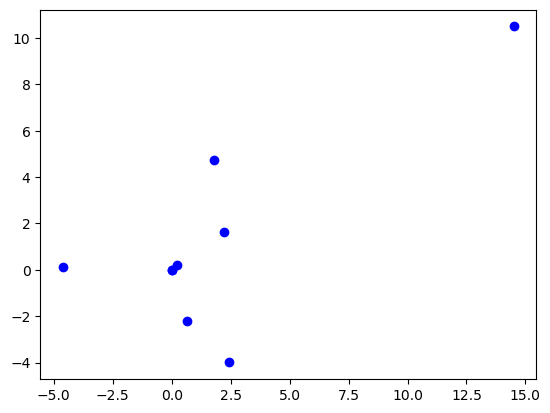

In [148]:
fig, ax = plt.subplots()
#ax.set_xlim(-10,10);
#ax.set_ylim(-10,10);
ax.scatter(X[:,0],X[:,1], c = 'b')
#ax.scatter(Xhist[5][9][0],Xhist[5][9][1],c = 'g')
#ax.scatter(targ[5][0], targ[5][1],c = 'r')
#ax.scatter(verts[:,0],verts[:,1], c = 'g')

#ax.scatter(v[:,0],v[:,1],c ='g')

In [109]:
tm = [[],[],[],[],[],[],[],[],[]]
for j in range(len(Xhist)):
    
    for i in range(9):
    
        tm[i].append(TukeyMedian2(Xhist[j][N[i]])+1)


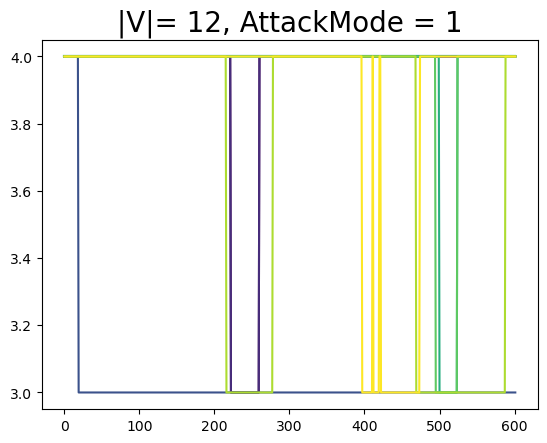

In [113]:
fig,ax = plt.subplots()
n = 12
f = 3
x = np.arange(602)
for i in range(9):
    ax.plot(x,tm[i], c = colors[i])
plt.title('|V|= '+str(12)+', AttackMode = 1',fontsize = 20);
plt.savefig("TukeyMedian"+str(n)+"_f"+str(f)+"mode1"+".jpg")

In [115]:
print(N)

[[3, 2, 4, 7, 0, 5, 9, 10, 11], [5, 4, 0, 7, 2, 3, 9, 10, 11], [3, 8, 4, 7, 2, 6, 9, 10, 11], [4, 0, 3, 7, 5, 8, 9, 10, 11], [2, 7, 3, 1, 8, 4, 9, 10, 11], [8, 4, 0, 3, 6, 1, 9, 10, 11], [0, 3, 6, 8, 1, 2, 9, 10, 11], [2, 0, 4, 8, 6, 3, 9, 10, 11], [8, 3, 4, 0, 1, 5, 9, 10, 11], [5, 1, 4, 0, 2, 6, 9, 10, 11], [1, 4, 8, 7, 3, 0, 9, 10, 11], [1, 8, 0, 7, 3, 2, 9, 10, 11]]


In [121]:
k = 0
temp = Xhist[0]
for i in range(1,len(Xhist)):
    temp = np.vstack((temp,Xhist[i]))
df = pd.DataFrame(temp)
df.to_csv("Xhist.csv")

In [72]:
k = 0
temp = Xhist[0][N[k]]
for i in range(1,len(Xhist)):
    temp = np.vstack((temp,Xhist[i][N[k]]))
df = pd.DataFrame(temp)
df.to_csv("D:\School\Cirens\Xhist.csv")

In [18]:
temp = Xhist[0][N[0]]
for x in Xhist[1: ]:
    temp = np.vstack((temp,x))
df = pd.DataFrame(temp)
df.to_csv("D:\School\Cirens\Xhist.csv")


In [62]:
temp = Xhist[300][N[0]]
df = pd.DataFrame(temp)
df.to_csv("D:\School\Cirens\Xhist.csv")

In [14]:
print(TukeyMedian2(Xhist[50]))
temp = Xhist[50]
df = pd.DataFrame(temp)
df.to_csv("D:\School\Cirens\Xhist.csv")

(4, [array([-1.15234826,  1.15234826]), array([-0.7870685 ,  1.36324263]), array([-1.15234826,  1.15234826]), array([-1.38613476,  0.74741816]), array([-0.7870685 ,  1.36324263]), array([-6.24089431e-16,  1.92776184e-16]), array([-7.69185075e-16,  4.44089210e-16]), array([-6.40987562e-16,  2.22044605e-16]), array([-6.24089431e-16,  1.92776184e-16]), array([-1.20447200e-15,  1.92776184e-16]), array([-6.57885693e-16,  1.92776184e-16]), array([-9.57421797e-01,  2.51401360e-16]), array([-7.69185075e-16,  4.44089210e-16]), array([-1.20447200e-15,  1.92776184e-16]), array([-3.84592537e-16,  6.66133815e-16]), array([-6.40987562e-16,  2.22044605e-16]), array([-6.57885693e-16,  1.92776184e-16]), array([-3.84592537e-16,  6.66133815e-16]), array([-1.38613476,  0.74741816]), array([-9.57421797e-01,  2.22044605e-16])])


In [13]:
depth,verts = TukeyMedian2(Xhist[198])
print(depth)
print(verts)

5
[array([-2.39756275e+00, -5.86357906e+15]), array([-2.39756275e+00, -5.86357906e+15])]


In [15]:
print(Xhist[198])

[[ 7.41808497e-01  0.00000000e+00]
 [ 6.42425003e-01  3.70904249e-01]
 [ 3.70904249e-01  6.42425003e-01]
 [ 4.54226701e-17  7.41808497e-01]
 [-3.70904249e-01  6.42425003e-01]
 [-6.42425003e-01  3.70904249e-01]
 [-7.41808497e-01  9.08453402e-17]
 [-6.42425003e-01 -3.70904249e-01]
 [-3.70904249e-01 -6.42425003e-01]
 [-2.19266692e+00  4.22278571e+00]
 [-4.21270921e-01 -8.94452822e-01]
 [-8.13443611e-01 -2.29022971e+00]]


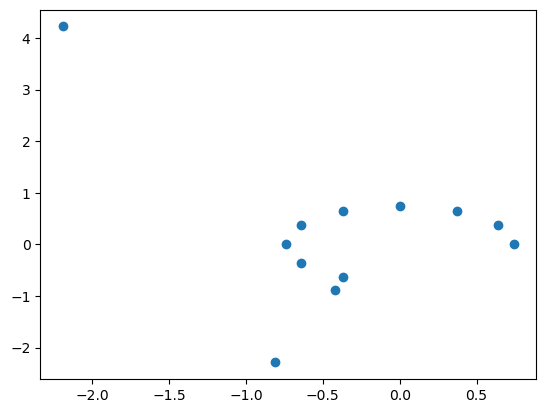

In [16]:
fig, ax = plt.subplots()
ax.scatter(Xhist[198][:,0], Xhist[198][:,1])
hold on;
ax.scatter(-2.3975,-5)

In [63]:
size = int(np.floor(2*n/3)+1)
n = np.arange(n);

combk = list(combinations(n,size));
safeX = [];
safeY =[];
dp1 =[]
first = True;
success = True;
safeHull = Polygon();
for comb in combk:
    Xc= np.zeros((size,2));
    j = 0;
    for idx in comb:
        Xc[j,:] = X[idx,:];
        j+=1;
    hullk = ConvexHull(Xc);
     
    dp1 = Polygon(Xc[hullk.vertices,:]);
    if safeHull.is_empty:
        safeHull = dp1;
    try:
        safeHull = safeHull.intersection(dp1);
    except:
        print("could not compute centerpoint for ",X)
        safeHull = safeHull
        success = False
if safeHull.geom_type == 'Polygon':
    safeX,safeY = np.array(safeHull.exterior.xy)

In [69]:
safeX,safeY = getCenterpoint(9,X,0);

ValueError: operands could not be broadcast together with shapes (9,) (0,) 

In [67]:
print(safeY)

[-3.16987298e+00 -3.41506351e+00 -2.50000000e+00  1.44328993e-15
  1.05662433e+00  1.83012702e+00 -9.15063509e-01 -1.83012702e+00
 -3.16987298e+00]
